In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

%matplotlib inline

# EXTRACT

In [3]:
cyclists_df = pd.read_excel('10 october 2017 Cyclist Numbers.xlsx')

In [4]:
pedestrians_df = pd.read_csv('brooklyn-bridge-automated-counts.csv')

# TRANSFORM

### Cyclists

In [5]:
cyclists_df.head()

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,Unnamed: 10
0,2017-10-01,Sunday,66.9,50.0,0.0,2297,4540,5046,4092,15975,NaN
1,2017-10-02,Monday,72.0,52.0,0.0,3387,7059,7616,5722,23784,NaN
2,2017-10-03,Tuesday,70.0,57.0,0.0,3386,7370,8161,6363,25280,NaN
3,2017-10-04,Wednesday,75.0,55.9,0.0,3412,7691,8136,6238,25477,NaN
4,2017-10-05,Thursday,82.0,64.9,0.0,3312,7034,7598,5998,23942,NaN


In [6]:
# Clean unnecssary columns
cyclists_drop_df = cyclists_df.drop(['Manhattan Bridge',
                  'Williamsburg Bridge', 
                  'Queensboro Bridge',
                  'Total',
                  'Unnamed: 10'], axis=1).copy()

cyclists_drop_df.rename(columns={'Date':'date',
                                 'Day':'day',
                                 'High Temp (°F)':'high_temp', 
                                 'Low Temp (°F)':'low_temp',
                                 'Precipitation':'precipitation',
                                 'Brooklyn Bridge':'cyclists'}, inplace=True)

In [7]:
# Clean junk data at bottom of CSV
cyclists_drop_df.dropna(inplace=True)

In [8]:
# Create Date_id column and normalize
cyclists_drop_df.reset_index(inplace=True)
cyclists_drop_df.rename(columns={'index':'date_id'}, inplace=True)
dates_df = cyclists_drop_df[['date_id', 'date']]
cyclists_drop_df.drop(['date'], axis=1, inplace=True)

In [9]:
cyclists_drop_df.head(10)

,date_id,day,high_temp,low_temp,precipitation,cyclists
0,0,Sunday,66.9,50.0,0.00,2297
1,1,Monday,72.0,52.0,0.00,3387
2,2,Tuesday,70.0,57.0,0.00,3386
3,3,Wednesday,75.0,55.9,0.00,3412
4,4,Thursday,82.0,64.9,0.00,3312
5,5,Friday,81.0,69.1,0.00,2982
6,6,Saturday,80.1,66.0,0.00,2750
7,7,Sunday,77.0,72.0,0.22,1235
8,8,Monday,75.9,72.0,0.26,898
9,9,Tuesday,80.1,66.0,0.00,3922


In [10]:
# Weekday_id column and normalize
weekday_df = pd.DataFrame(cyclists_drop_df['day'].unique())
weekday_df.reset_index(inplace=True)
weekday_df.rename(columns={'index':'weekday_id', 0:'day'}, inplace=True)

In [11]:
cyclists_id_df = cyclists_drop_df.merge(weekday_df, how='left', left_on='day', right_on='day')
cyclists_id_df.drop('day', axis=1, inplace=True)

# Reorder columns
cyclists_id_df = cyclists_id_df[['date_id', 
                                 'weekday_id', 
                                 'high_temp',
                                 'low_temp',
                                 'precipitation',
                                 'cyclists']]

In [12]:
# Create cyclist_id
cyclists_id_df.reset_index(inplace=True)
cyclists_id_df.rename(columns={'index':'cyclist_id'}, inplace=True)

In [13]:
cyclists_id_df.head()

,cyclist_id,date_id,weekday_id,high_temp,low_temp,precipitation,cyclists
0,0,0,0,66.9,50.0,0.0,2297
1,1,1,1,72.0,52.0,0.0,3387
2,2,2,2,70.0,57.0,0.0,3386
3,3,3,3,75.0,55.9,0.0,3412
4,4,4,4,82.0,64.9,0.0,3312


In [14]:
weekday_df

,weekday_id,day
0,0,Sunday
1,1,Monday
2,2,Tuesday
3,3,Wednesday
4,4,Thursday
5,5,Friday
6,6,Saturday


In [15]:
dates_df.head()

,date_id,date
0,0,2017-10-01
1,1,2017-10-02
2,2,2017-10-03
3,3,2017-10-04
4,4,2017-10-05


### Pedestrians

In [16]:
pedestrians_df.head()

,hour_beginning,location,Pedestrians,Towards Manhattan,Towards Brooklyn,weather_summary,temperature,precipitation,lat,long
0,10/01/17,Brooklyn Bridge,44,30,14,clear-night,52.0,0.0001,40.708164,-73.999509
1,10/01/17,Brooklyn Bridge,30,17,13,partly-cloudy-night,53.0,0.0002,40.708164,-73.999509
2,10/01/17,Brooklyn Bridge,25,13,12,partly-cloudy-night,52.0,0.0000,40.708164,-73.999509
3,10/01/17,Brooklyn Bridge,20,11,9,partly-cloudy-night,51.0,0.0000,40.708164,-73.999509
4,10/01/17,Brooklyn Bridge,18,10,8,partly-cloudy-night,51.0,0.0000,40.708164,-73.999509


In [17]:
# Drop unncessary columns
pedestrians_drop_df = pedestrians_df.drop(['location', 
                                           'Towards Manhattan',
                                           'Towards Brooklyn',
                                           'weather_summary',
                                           'temperature',
                                           'precipitation',
                                           'lat', 
                                           'long'], axis=1)

In [18]:
# Records are hourly, so groupby and sum to get daily totals
pedestrians_group_df = pedestrians_drop_df.groupby('hour_beginning').sum().reset_index()\
    .rename(columns={'Pedestrians':'pedestrians', 'hour_beginning':'date'})

In [19]:
# Filter by dates to match cyclist dataset
pedestrians_group_df = pedestrians_group_df[(pedestrians_group_df.date >= '10/01/17') & (pedestrians_group_df.date < '11/01/17')]

In [20]:
# Create date_id from date index
pedestrians_group_df = pedestrians_group_df.reset_index(drop=True).reset_index().rename(columns={'index':'date_id'})
pedestrians_group_df.drop('date', axis=1, inplace=True)

In [21]:
pedestrians_group_df

,date_id,pedestrians
0,0,25687
1,1,18028
2,2,16580
3,3,17533
4,4,17980
5,5,20089
6,6,31610
7,7,19993
8,8,8985
9,9,20821


# LOAD

In [23]:
# Create connection database
connection_string = "postgres:julia@localhost:5432/ETL_db"
engine = create_engine(f'postgresql://{connection_string}')

if not database_exists(engine.url):
    create_database(engine.url)

In [24]:
con = engine.connect()

In [25]:
# Drop tables if cleaning out Postgres to try all this again
con.execute('DROP TABLE IF EXIStS pedestrians')
con.execute('DROP TABLE IF EXISTS dates')
con.execute('DROP TABLE IF EXISTS weekdays')
con.execute('DROP TABLE IF EXISTS cyclists')

In [26]:
# Create pedestrians table and add df to db
con.execute('CREATE TABLE pedestrians (date_id INT PRIMARY KEY, pedestrians INT)')
pedestrians_group_df.to_sql(name='pedestrians', con=engine, if_exists='append', index=False)

In [27]:
# Create dates table and add df to db
con.execute('CREATE TABLE dates (date_id INT PRIMARY KEY, date DATE)')
dates_df.to_sql(name='dates', con=engine, if_exists='append', index=False)

In [28]:
# Create weekdays table and add df to db
con.execute('CREATE TABLE weekdays (weekday_id INT PRIMARY KEY, day TEXT)')
weekday_df.to_sql(name='weekdays', con=engine, if_exists='append', index=False)

In [29]:
# Create cyclists table and add df to db
con.execute('''CREATE TABLE cyclists (cyclist_id INT PRIMARY KEY, date_id INT, weekday_id INT, 
    high_temp FLOAT, low_temp FLOAT, precipitation FLOAT, cyclists INT)''')
cyclists_id_df.to_sql(name='cyclists', con=engine, if_exists='append', index=False)            

# QUERY

In [30]:
# Get day of week, high temp, pedestrians, cyclists

In [31]:
query_df = pd.read_sql_query('''SELECT cyclists, pedestrians, day, high_temp, precipitation 
                    FROM cyclists JOIN pedestrians ON cyclists.date_id = pedestrians.date_id
                    JOIN weekdays ON cyclists.weekday_id = weekdays.weekday_id''', con=engine)

In [32]:
query_df.head()

,cyclists,pedestrians,day,high_temp,precipitation
0,2297,25687,Sunday,66.9,0.0
1,3387,18028,Monday,72.0,0.0
2,3386,16580,Tuesday,70.0,0.0
3,3412,17533,Wednesday,75.0,0.0
4,3312,17980,Thursday,82.0,0.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the 

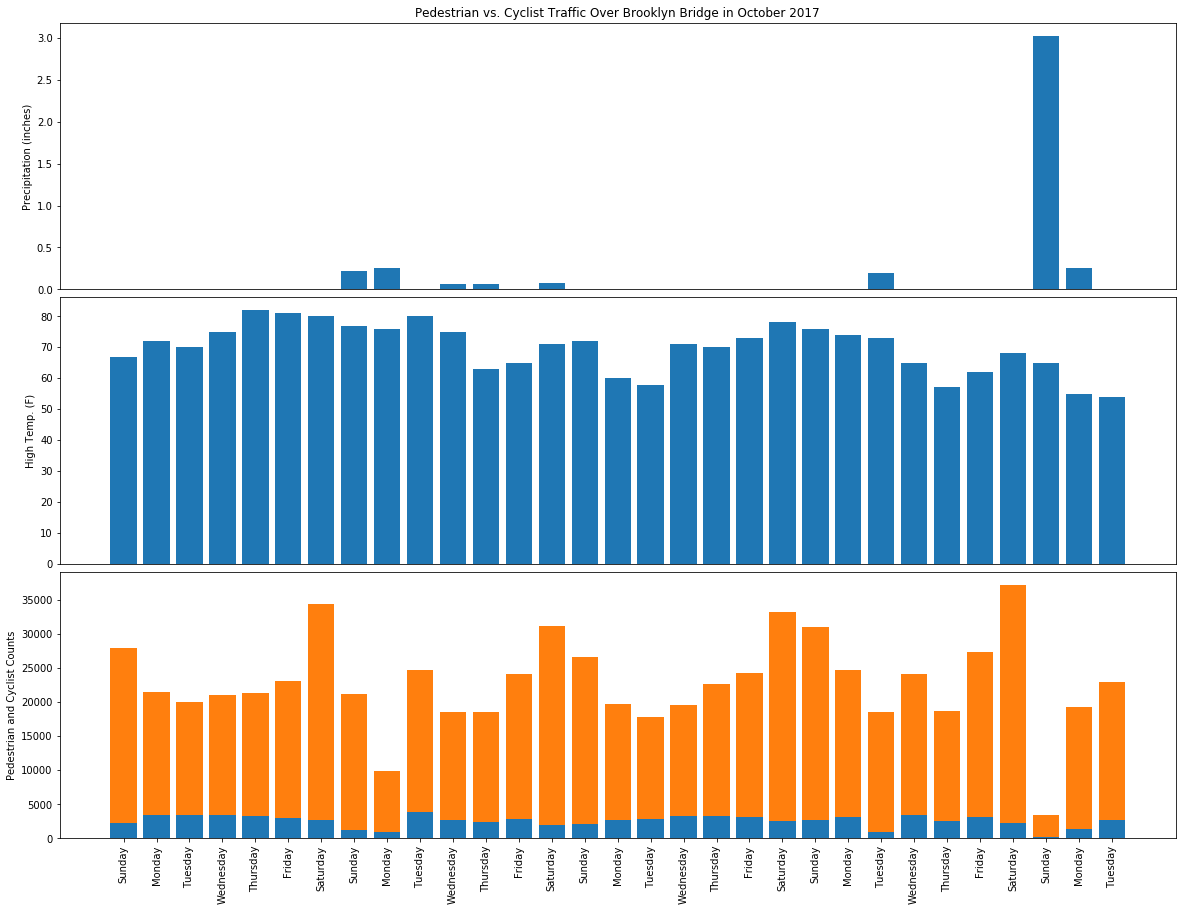

In [33]:
fig, ax = plt.subplots(figsize=(20,15))
fig.subplots_adjust(hspace=0.03, wspace=0)

indices = query_df.index.values
labels = query_df.day

plt.subplot(3, 1, 1)
plt.title("Pedestrian vs. Cyclist Traffic Over Brooklyn Bridge in October 2017")
plt.bar(indices, query_df.precipitation)
ax1 = fig.add_subplot(311)
ax1.set_ylabel("Precipitation (inches)")
plt.xticks([], [])

plt.subplot(3, 1, 2)
plt.bar(indices, query_df.high_temp)
ax2 = fig.add_subplot(312)
ax2.set_ylabel("High Temp. (F)")
plt.xticks([], [])

plt.subplot(3, 1, 3)
plt.bar(indices, query_df.cyclists)
plt.bar(indices, query_df.pedestrians, bottom=query_df.cyclists)
ax3 = fig.add_subplot(313)
ax3.set_ylabel("Pedestrian and Cyclist Counts")
ax.set_xlabel("Days of the week")
plt.xticks(indices, labels, rotation='vertical');